In [1]:
import pickle

from pathlib import Path
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from meth5 import MetH5File

from nanoepitools.plotting.general_plotting import PlotArchiver, plot_2d_density
from nanoepitools.reference_cpgs import ReferenceCpGs

from benchmark_pycometh.simulation.nanopolish_simulator import OmicsSimlaLoader
from benchmark_pycometh.utils import unions
from benchmark_pycometh.config import module_config
from benchmark_pycometh.diffmet.asm_results import Results

In [2]:
pa = PlotArchiver("simulation", headless=False, config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})
reference_cpgs = ReferenceCpGs("/home/r933r/data/resource/human/hg19/hg19_no_chr.fa")
simulated_m5 = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/diffmet_merged_2_rewritten.m5"
results_cache_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/all_results_cache.pkl"
load_from_cache=False

In [3]:
def get_result_file(caller, segmentation=None, test=None, ihw=False, segments_per_window=None, window_size=None):
    simdir = Path("/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/")
    if caller == "gt":
        return simdir.joinpath("wgbs/merged/changepoints.txt")
    simdir = simdir.joinpath(segmentation)
    if caller == "methcp":
        return simdir.joinpath("methcp_dmr_2.bed")
    ihw = f"ihw_{'yes' if ihw else 'no'}"
    if segmentation == "pycometh":
        simfile = f"diffmet_{window_size}_{segments_per_window}_hyp_{test}_{ihw}.tsv"
        return simdir.joinpath("diffmet", simfile)
    if caller == "pycometh":
        return simdir.joinpath(f"pycometh_methcomp/diffmet/diffmet_hyp_{test}_{ihw}.tsv")

def get_all_result_files():
    yield {"key":"GT", "file":get_result_file("gt"), "caller": "gt"}
    yield {"key":"MethCP", "file":get_result_file("methcp", "methcp"), "caller": "methcp"}
    for label, segmentation in  ("PycoMeth", "pycometh"), ("PycoMeth (MethylKit)", "methylkit"), ("PycoMeth (MethCP)", "methcp"):
        for ihw in True, False:
            for test_label, test in ("BS Diff", "bs_diff"), ("LLR-Diff", "llr_diff"), ("Fisher-E","count_dependency"):
                name = f"{label} {test_label}{' (IHW)' if ihw else ''}"
                if segmentation == "pycometh":
                    yield {"key": name + " coarse", "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw, 16, 600)}
                    yield {"key": name, "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw, 16, 300)}
                else:
                    yield {"key": name, "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw)}

In [4]:
if load_from_cache:
    with open(results_cache_file, "rb") as f:
        results = pickle.load(f)
else:
    results = Results(reference_cpgs, simulated_m5, read_group_key="sample")

In [9]:
import importlib
import benchmark_pycometh.diffmet.asm_results
importlib.reload(benchmark_pycometh.diffmet.asm_results)
results.__class__ = benchmark_pycometh.diffmet.asm_results.Results

In [11]:
for res_config in get_all_result_files():
    if res_config["key"] not in results.segments:
        results.load_segments(**res_config)

with open(results_cache_file, "bw") as f:
    del results.reference_cpgs.ref
    pickle.dump(results, f)

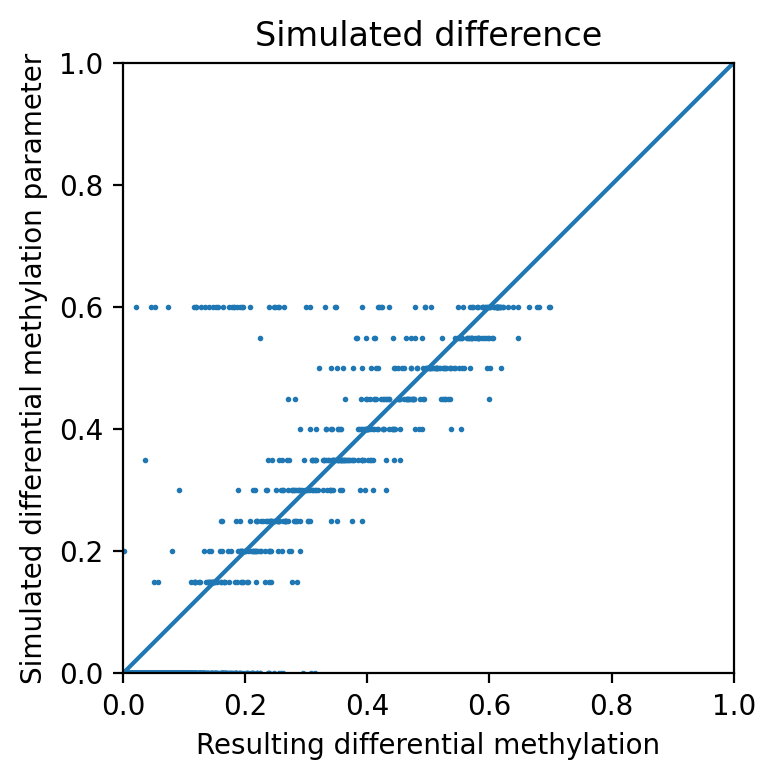

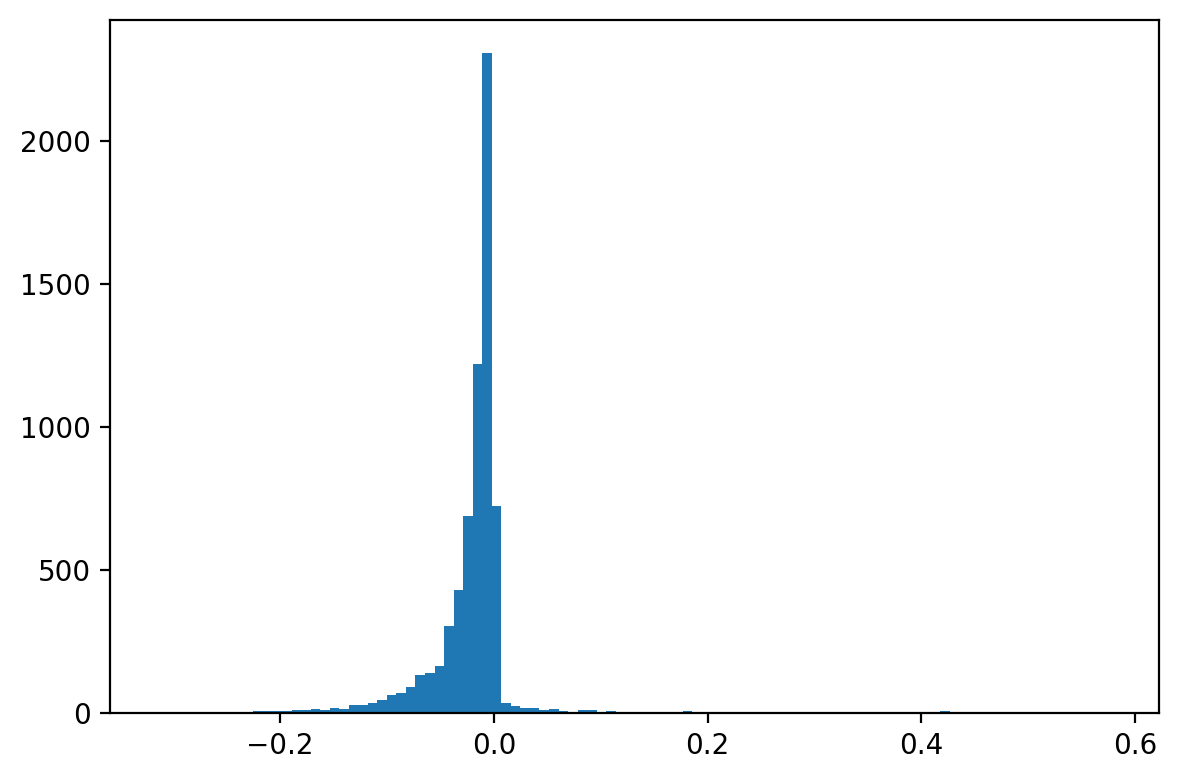

In [12]:
pa.figure()
plt.title("Simulated difference")
plt.scatter(results.segments["GT"]["diffmet"], np.abs(results.segments["GT"]["theta"]), s=1)
plt.xlabel("Resulting differential methylation")
plt.ylabel("Simulated differential methylation parameter")
plt.plot([0,1], [0,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect("equal")
pa.saveandshow("simulated_difference_vs_parameters")

pa.figure()
plt.hist(np.abs(results.segments["GT"]["theta"]) - results.segments["GT"]["diffmet"], bins=100)
plt.show()

In [91]:

class ResultComparer:
    def __init__(self, segments):
        self.segments = {k:v.copy() for k,v in segments.items()}

    def remove_cpgs_not_in_gt(self, gt_key):
        """
        Removing a small number of CpGs that fell through the cracks
        as they are in between block sin the simulation
        """
        allowed_cgs = unions(self.segments[gt_key]["CpGs"])
        for key in self.segments:
            if key == gt_key:
                continue
            self.segments[key]["CpGs"] = self.segments[key]["CpGs"].map(lambda cpgs: cpgs.intersection(allowed_cgs))

    def get(self, key, diffmet_threshold=0.1, below_threshold=False, theta_threshold=0, pval_threshold = 1):
        ret = self.segments[key]

        idx = ret["diffmet"].map(lambda x: abs(x)>=diffmet_threshold)
        if theta_threshold != 0:
            idx = idx & ret["theta"].map(lambda x: abs(x) >= theta_threshold)

        if below_threshold:
            idx = ~idx

        if pval_threshold < 1:
            idx = idx & (ret["adj_pvalue"] < pval_threshold)

        return ret.loc[idx]

    def compute_tpr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold=0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_pos = self.get(gt, diffmet_threshold=0, theta_threshold=theta_threshold)
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_gt_pos = len(gt_pos_cgs)
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        if num_gt_pos == 0:
            return np.nan
        return num_true_pos / num_gt_pos

    def compute_precision(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold=0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_pos = self.get(gt, diffmet_threshold=0, theta_threshold=theta_threshold)
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        num_pred = len(pred_cgs)

        if num_pred == 0:
            return np.nan
        return num_true_pos / num_pred

    def compute_fpr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold = 0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_neg = self.get(gt, diffmet_threshold=0, below_threshold=True, theta_threshold=theta_threshold)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        num_gt_neg = len(gt_neg_cgs)
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        if num_gt_neg == 0:
            return np.nan
        return num_false_pos / num_gt_neg

    def compute_fdr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold=0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_neg = self.get(gt, diffmet_threshold=0, below_threshold=True, theta_threshold=theta_threshold)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        num_pred = len(pred_cgs)
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        if num_pred == 0:
            return np.nan
        return num_false_pos / num_pred

    def compute_discovery_counts(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold=0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])

        gt_neg = self.get(gt, diffmet_threshold=0, below_threshold=True, theta_threshold=theta_threshold)
        gt_pos = self.get(gt, diffmet_threshold=0, theta_threshold=theta_threshold)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        return num_false_pos, num_true_pos

In [124]:
def plot_measures(gt, title="", figurename=None, tool_colors=None, tool_patterns={}, theta_threshold = 0.1, diffmet_threshold=0.15):
    if tool_colors is None:
        tool_colors = {k:v for k,v in results.colors.items() if k != "GT"}
    if tool_patterns is None:
        tool_patterns = {k:v for k,v in results.patterns.items() if k != "GT"}

    recall = []
    precision = []
    f1 = []

    rc = ResultComparer(results.segments)
    rc.segments["GT"] = gt
    rc.remove_cpgs_not_in_gt("GT")

    for tool in tool_colors:
        p = 1-rc.compute_fdr("GT", tool, pval_threshold=0.05, theta_threshold=theta_threshold, diffmet_threshold=diffmet_threshold)
        r = rc.compute_tpr("GT", tool, pval_threshold=0.05, theta_threshold=theta_threshold, diffmet_threshold=diffmet_threshold)
        f = 2*(p*r)/(p+r)

        recall.append(r)
        precision.append(p)
        f1.append(f)

    pa.figure(figsize=(10,5))
    plt.title(title)
    x = 0
    for y, (tool, color) in zip(recall, tool_colors.items()):
        plt.bar(x,y, width=1, color=color, hatch=tool_patterns.get(tool, ""))
        x+=1

    x+=1
    for y, (tool, color) in zip(precision, tool_colors.items()):
        plt.bar(x,y, width=1, color=color, hatch=tool_patterns.get(tool, ""))
        x+=1

    x+=1
    for y, (tool, color) in zip(f1, tool_colors.items()):
        plt.bar(x,y, width=1, color=color, label=tool, hatch=tool_patterns.get(tool, ""))
        x+=1

    xticks_locs = np.arange(len(tool_colors)/2, (len(tool_colors)+1)*3, len(tool_colors)+1)
    plt.xticks(xticks_locs, ["Recall", "Precision", "F1-score"])

    plt.legend(loc=(1.04,0))
    plt.ylim(0,1)
    plt.tight_layout()
    pa.saveandshow(figurename)

In [125]:
results.colors = {"GT": "gray"}
for key in results.segments:
    if key == "MethCP":
        results.colors[key] = "#88498F"
    elif "(MethCP)" in key:
        results.colors[key] = "#C492B1"
    elif "(MethylKit)" in key:
        results.colors[key] = "#49C6E5"
    elif "coarser" in key:
        results.colors[key] = "#C96300"
    elif "coarse" in key:
        results.colors[key] = "#ED7400"
    else:
        results.colors[key] = "#D58936"

results.patterns = {}
for key in results.segments:
    if "LLR-Diff" in key:
        if "IHW" in key:
            results.patterns[key] = "O"
        else:
            results.patterns[key] = "/"
    elif "BS Diff" in key:
        if "IHW" in key:
            results.patterns[key] = "."
        else:
            results.patterns[key] = "\\"
    elif "Fisher-E" in key:
        if "IHW" in key:
            results.patterns[key] = "o"
        else:
            results.patterns[key] = "-"

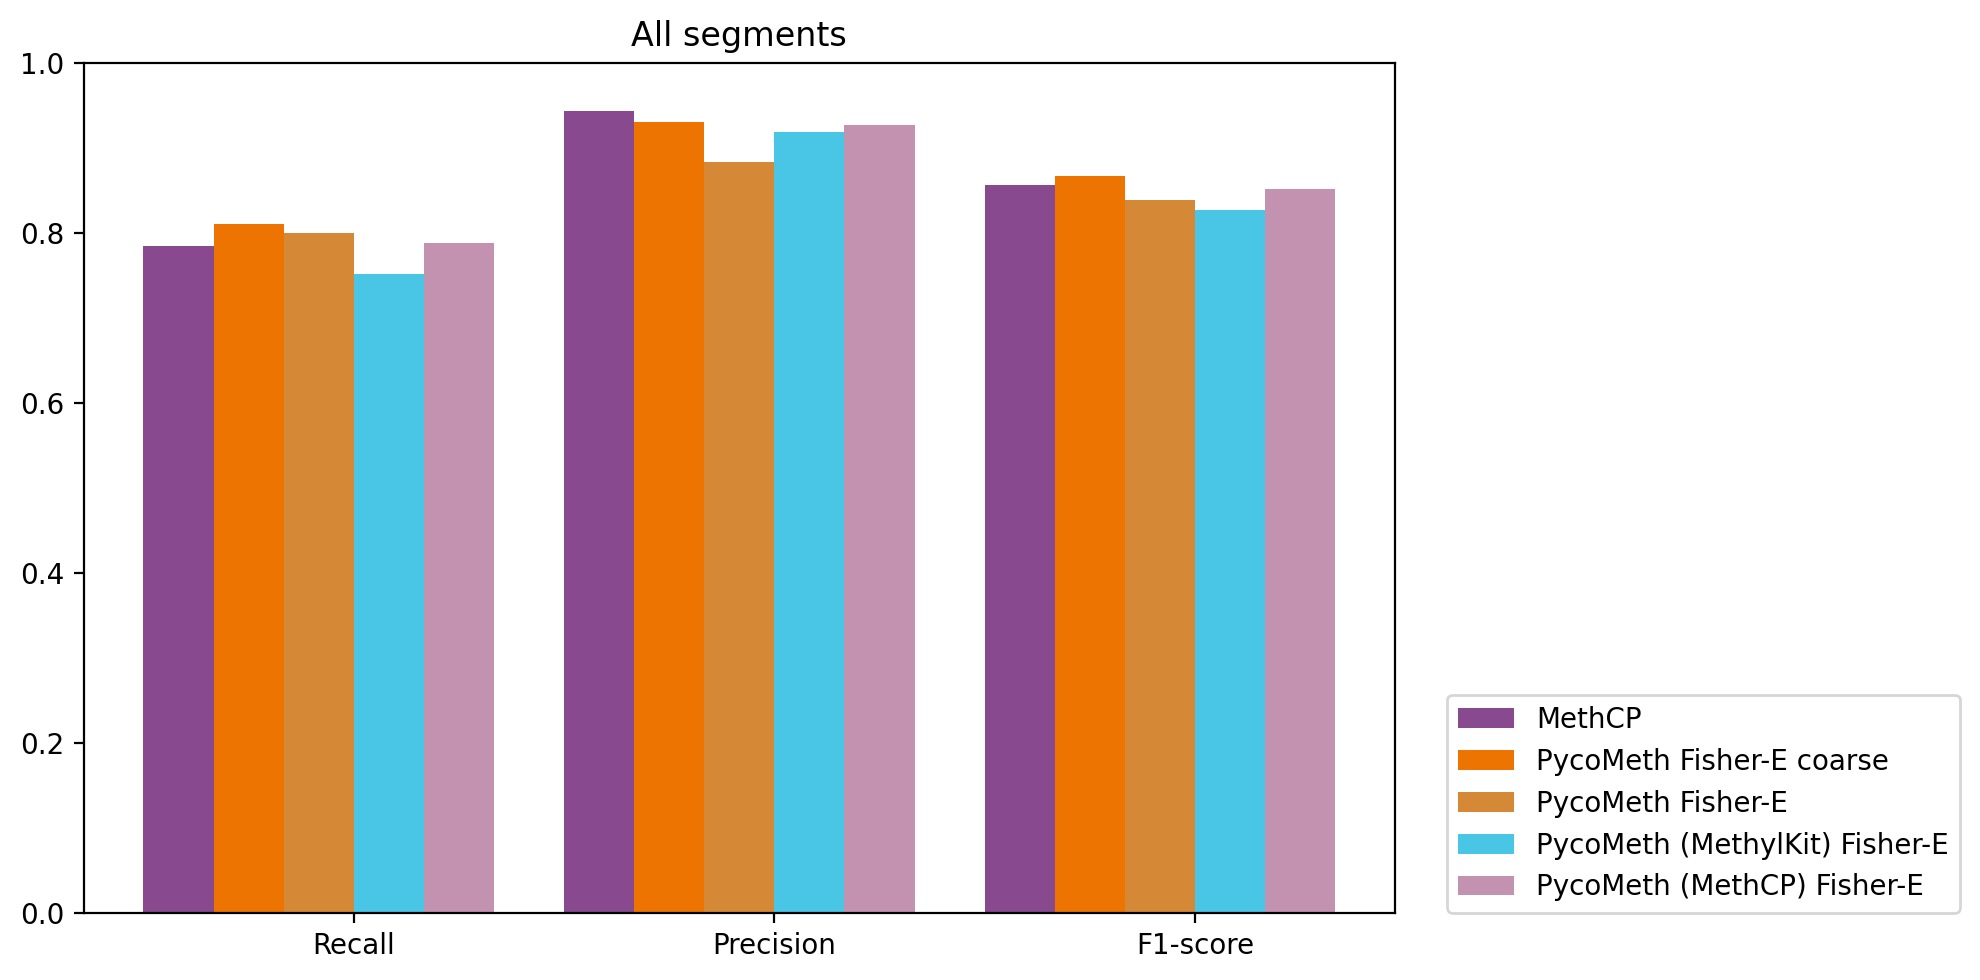

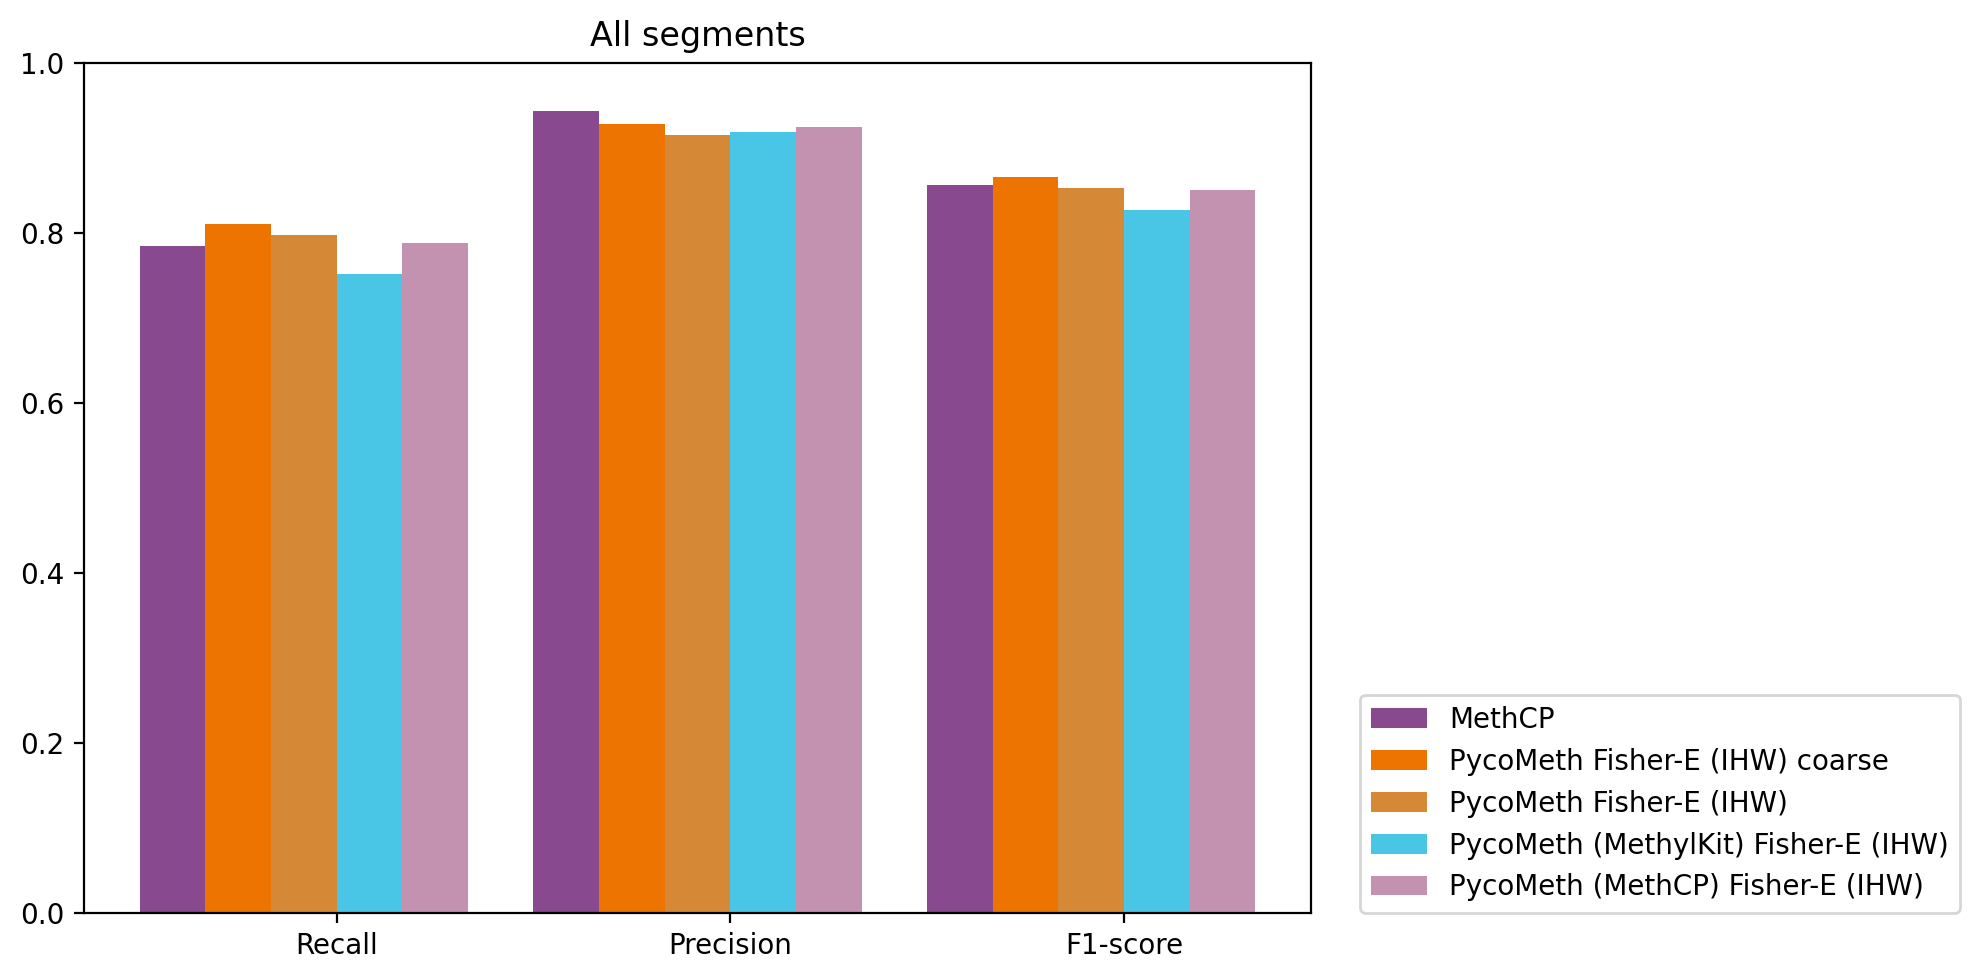

In [142]:
tools_include = ["MethCP", "PycoMeth Fisher-E coarse", "PycoMeth Fisher-E", "PycoMeth (MethylKit) Fisher-E", "PycoMeth (MethCP) Fisher-E"]
tool_colors = {k:results.colors[k] for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "f1_segmentations_fisher", tool_colors=tool_colors)

tools_include = ["MethCP", "PycoMeth Fisher-E (IHW) coarse", "PycoMeth Fisher-E (IHW)", "PycoMeth (MethylKit) Fisher-E (IHW)", "PycoMeth (MethCP) Fisher-E (IHW)"]
tool_colors = {k:results.colors[k] for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "f1_segmentations_fisher_ihw", tool_colors=tool_colors)

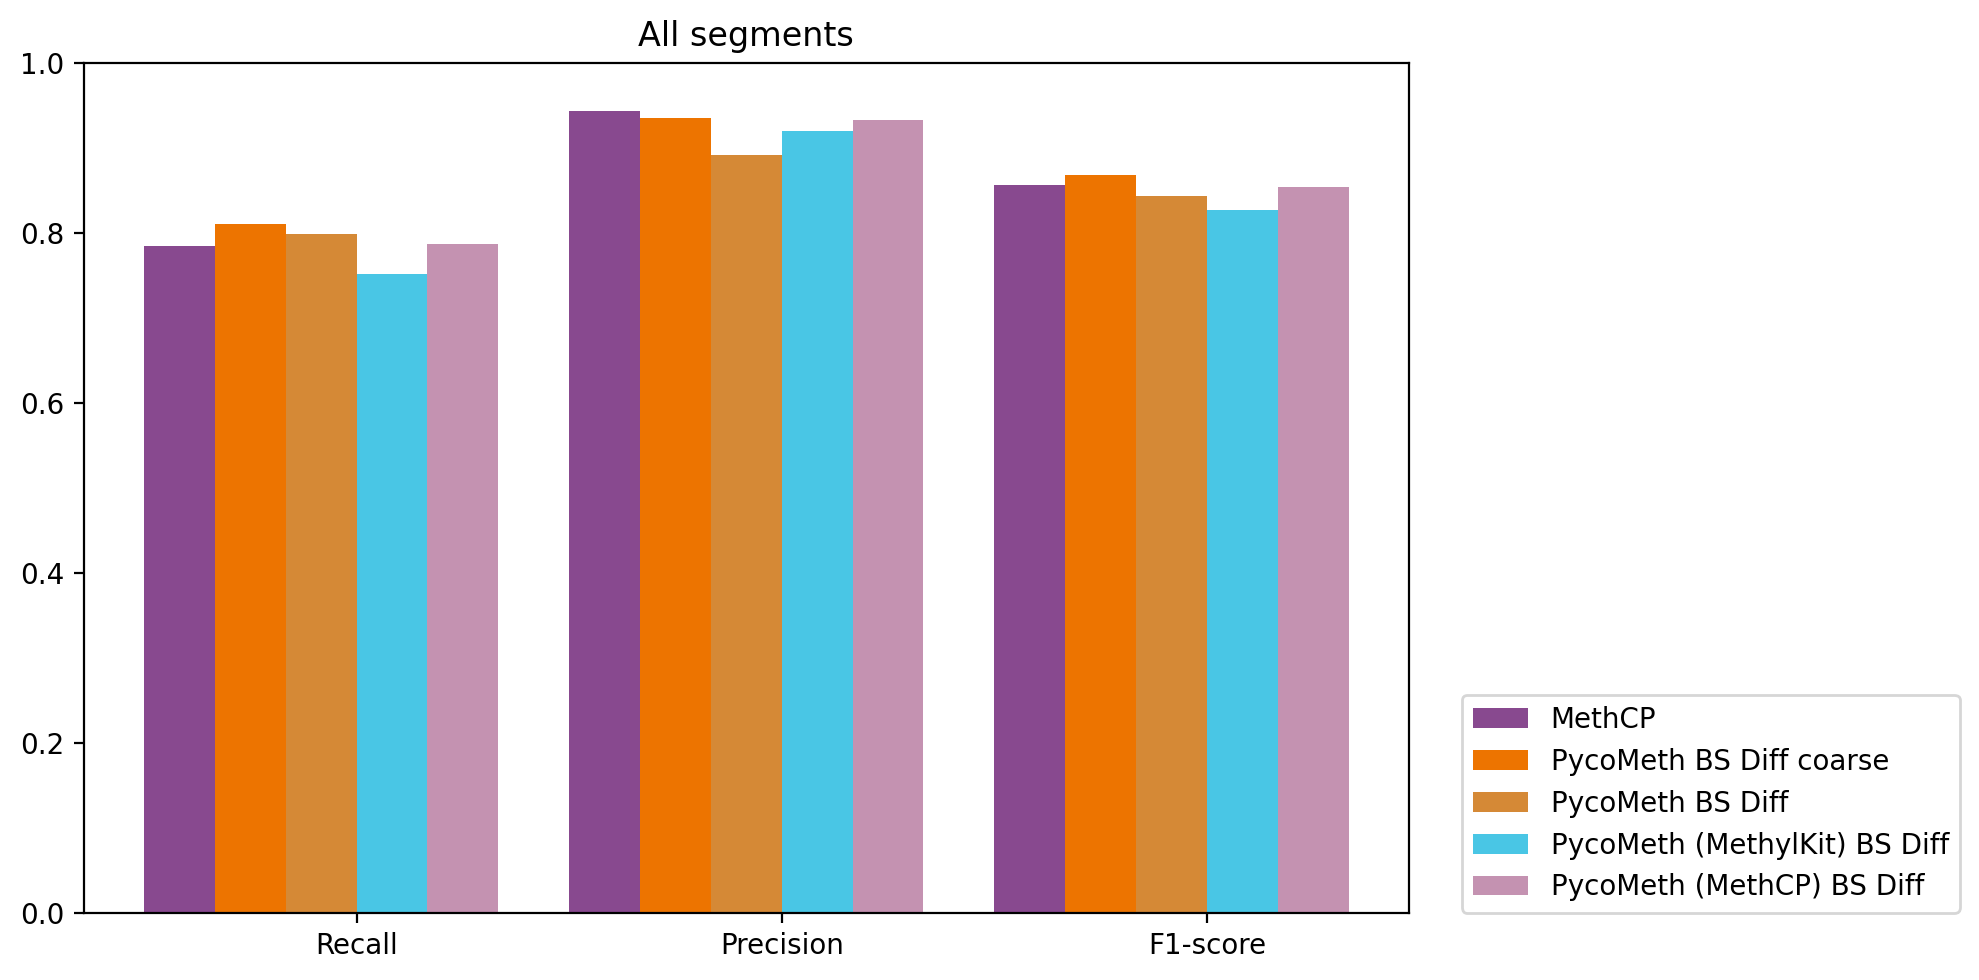

In [127]:
tools_include = ["MethCP", "PycoMeth BS Diff coarse", "PycoMeth BS Diff coarse", "PycoMeth BS Diff", "PycoMeth (MethylKit) BS Diff", "PycoMeth (MethCP) BS Diff"]
tool_colors = {k:results.colors[k] for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "f1_segmentations_bsdiff", tool_colors=tool_colors)

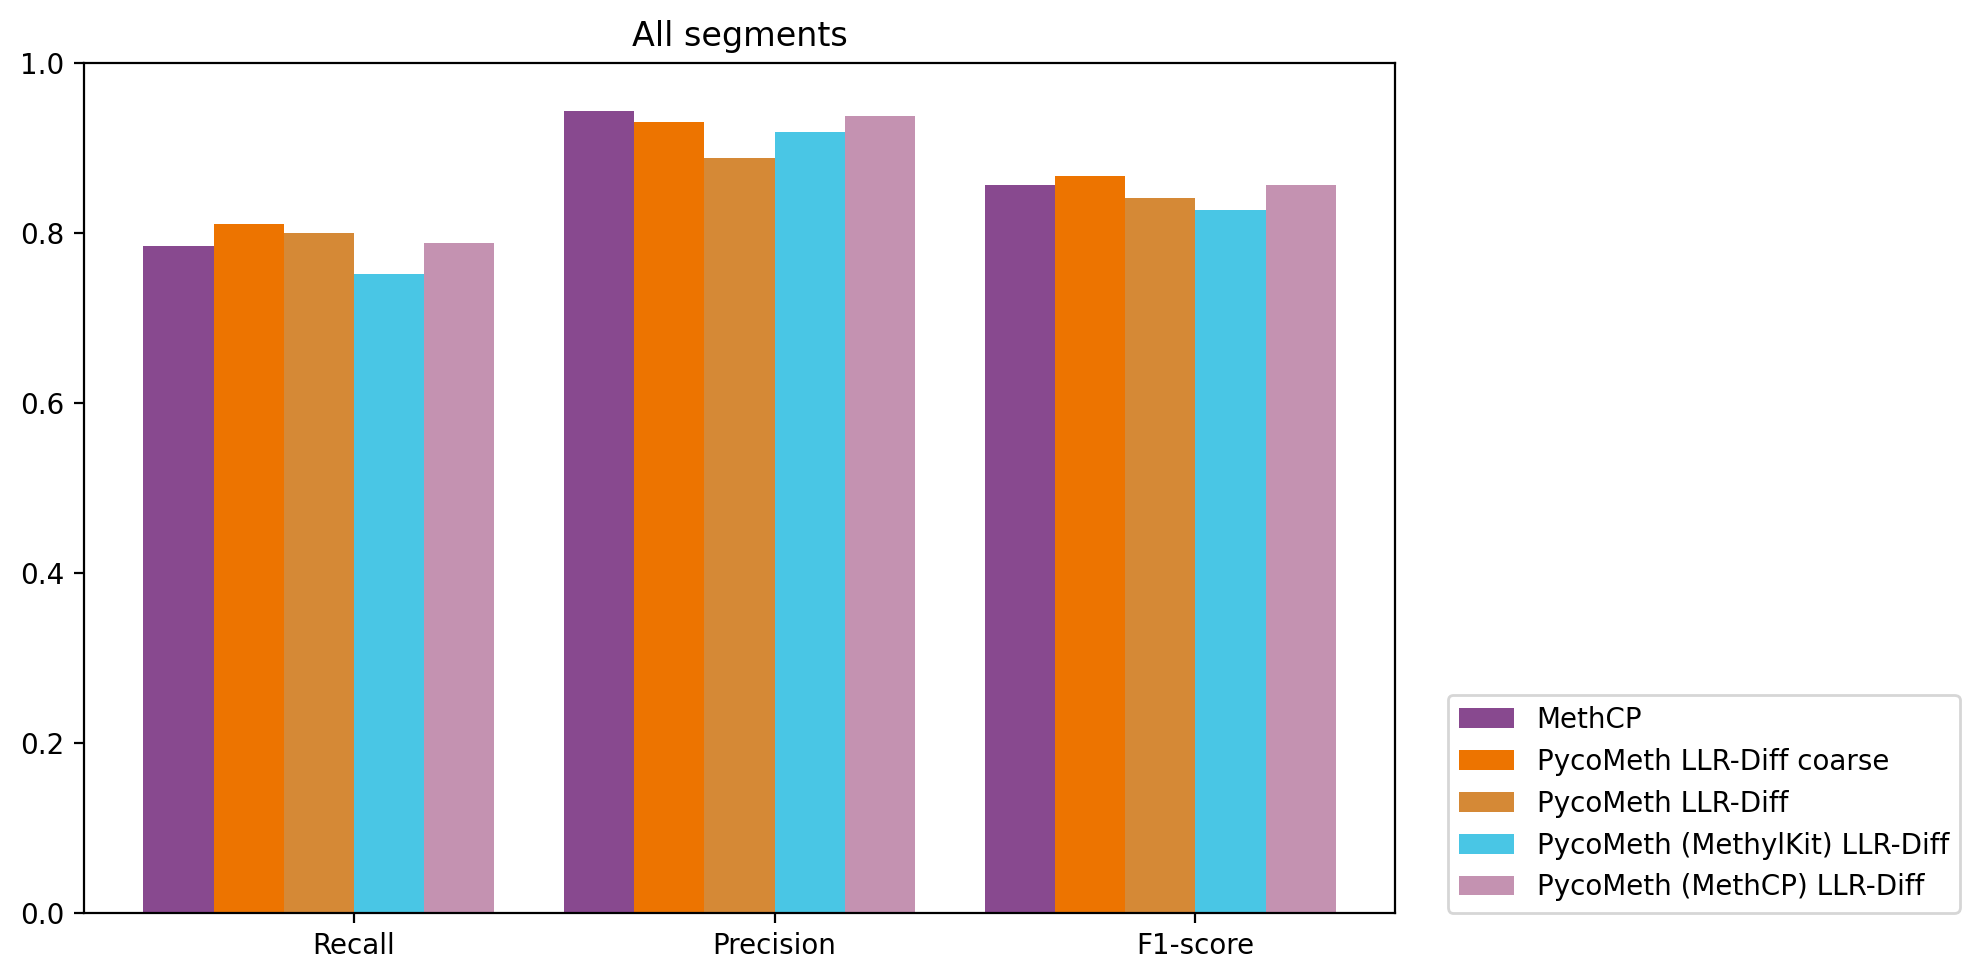

In [128]:
tools_include = ["MethCP", "PycoMeth LLR-Diff coarse", "PycoMeth LLR-Diff", "PycoMeth (MethylKit) LLR-Diff", "PycoMeth (MethCP) LLR-Diff"]
tool_colors = {k:results.colors[k] for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "f1_segmentations_llrdiff", tool_colors=tool_colors)

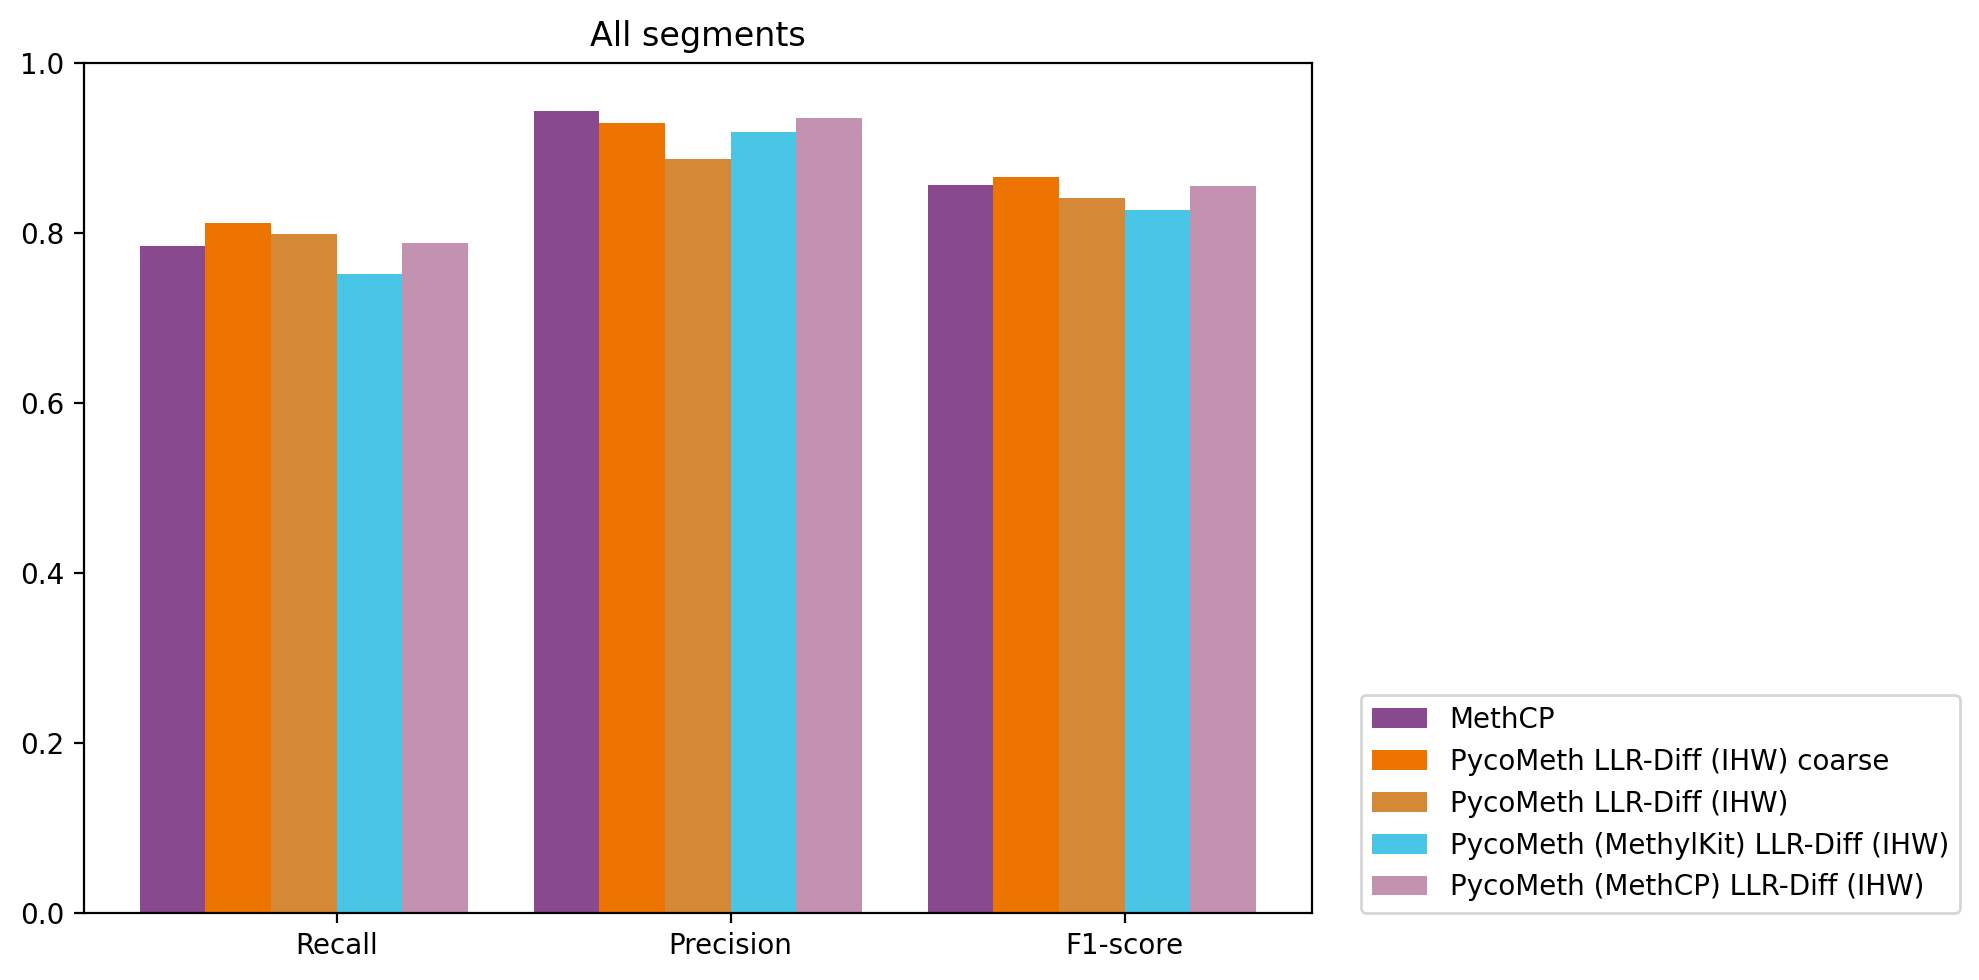

In [129]:
tools_include = ["MethCP", "PycoMeth LLR-Diff (IHW) coarse", "PycoMeth LLR-Diff (IHW)", "PycoMeth (MethylKit) LLR-Diff (IHW)", "PycoMeth (MethCP) LLR-Diff (IHW)"]
tool_colors = {k:results.colors[k] for k in tools_include}
tool_patterns = {k:results.patterns.get(k,"") for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "f1_segmentations_llrdiff_ihw", tool_colors=tool_colors)

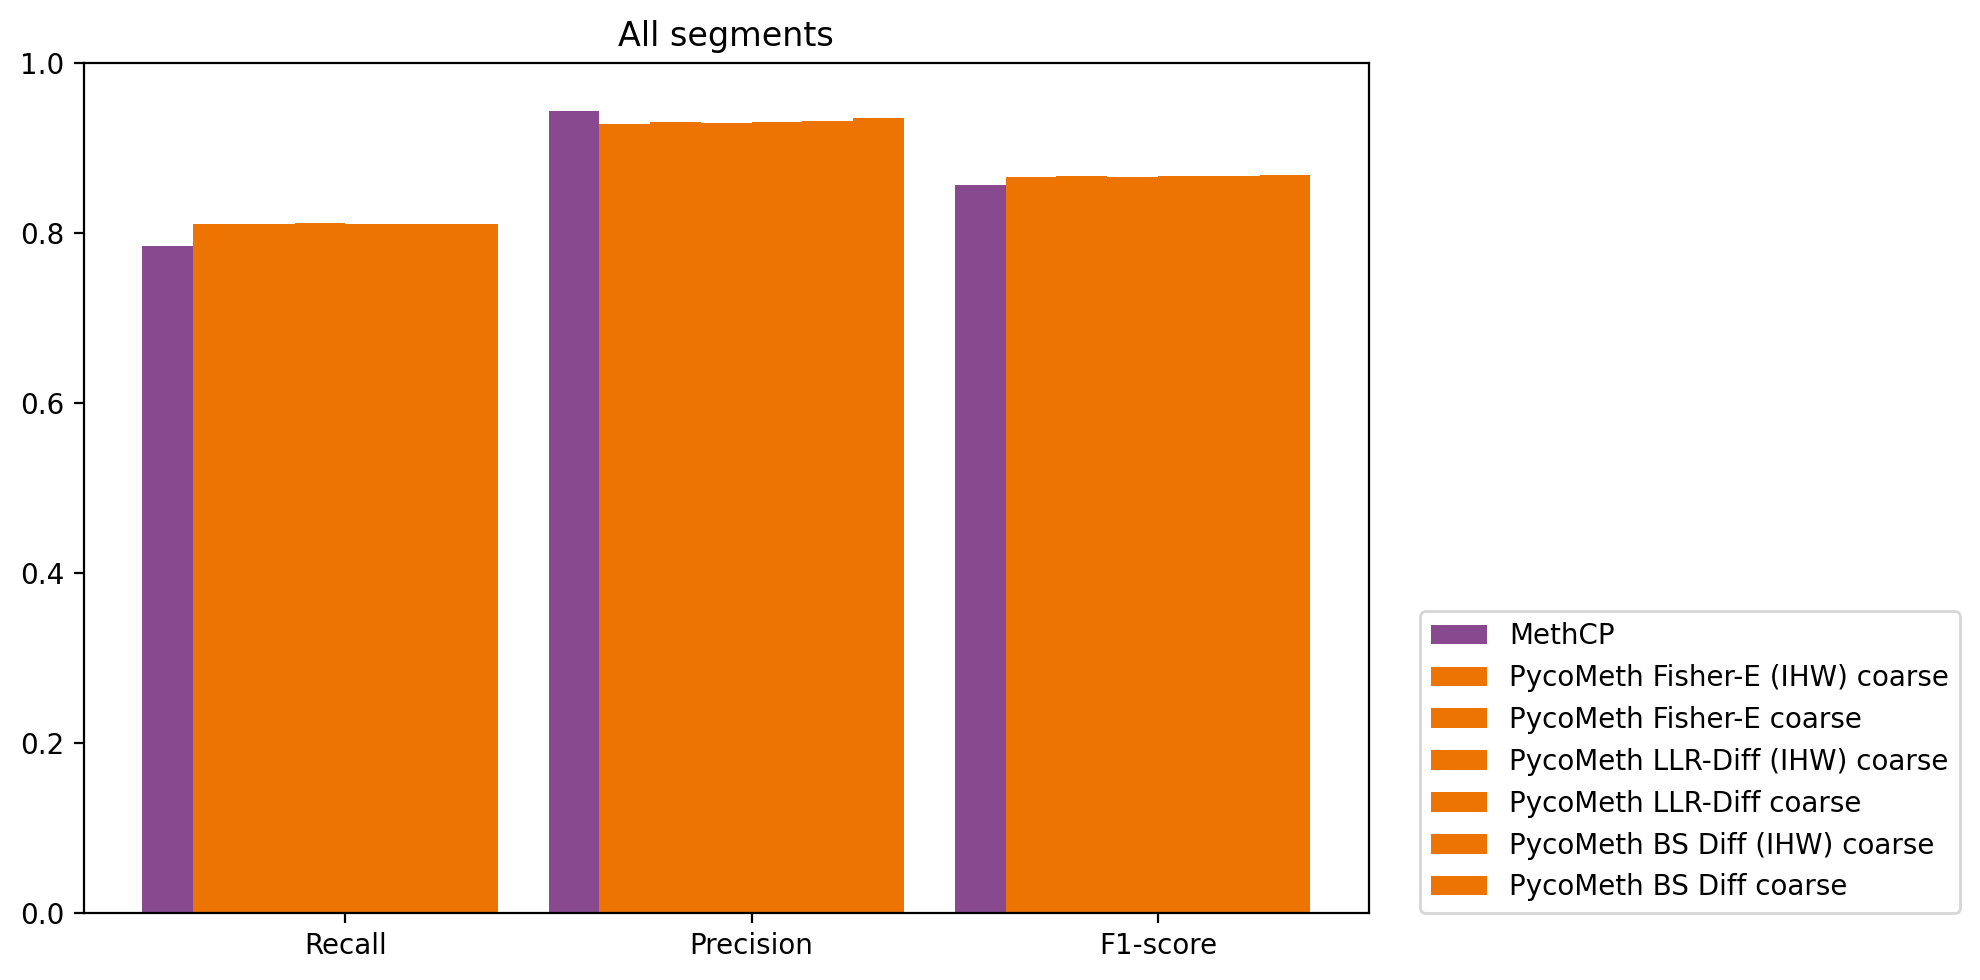

In [146]:
tools_include = ["MethCP", "PycoMeth Fisher-E (IHW) coarse", "PycoMeth Fisher-E coarse", "PycoMeth LLR-Diff (IHW) coarse", "PycoMeth LLR-Diff coarse", "PycoMeth BS Diff (IHW) coarse", "PycoMeth BS Diff coarse"]
tool_colors = {k:results.colors[k] for k in tools_include}
tool_patterns = {k:results.patterns.get(k,"") for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "f1_tests", tool_colors=tool_colors, tool_patterns={})

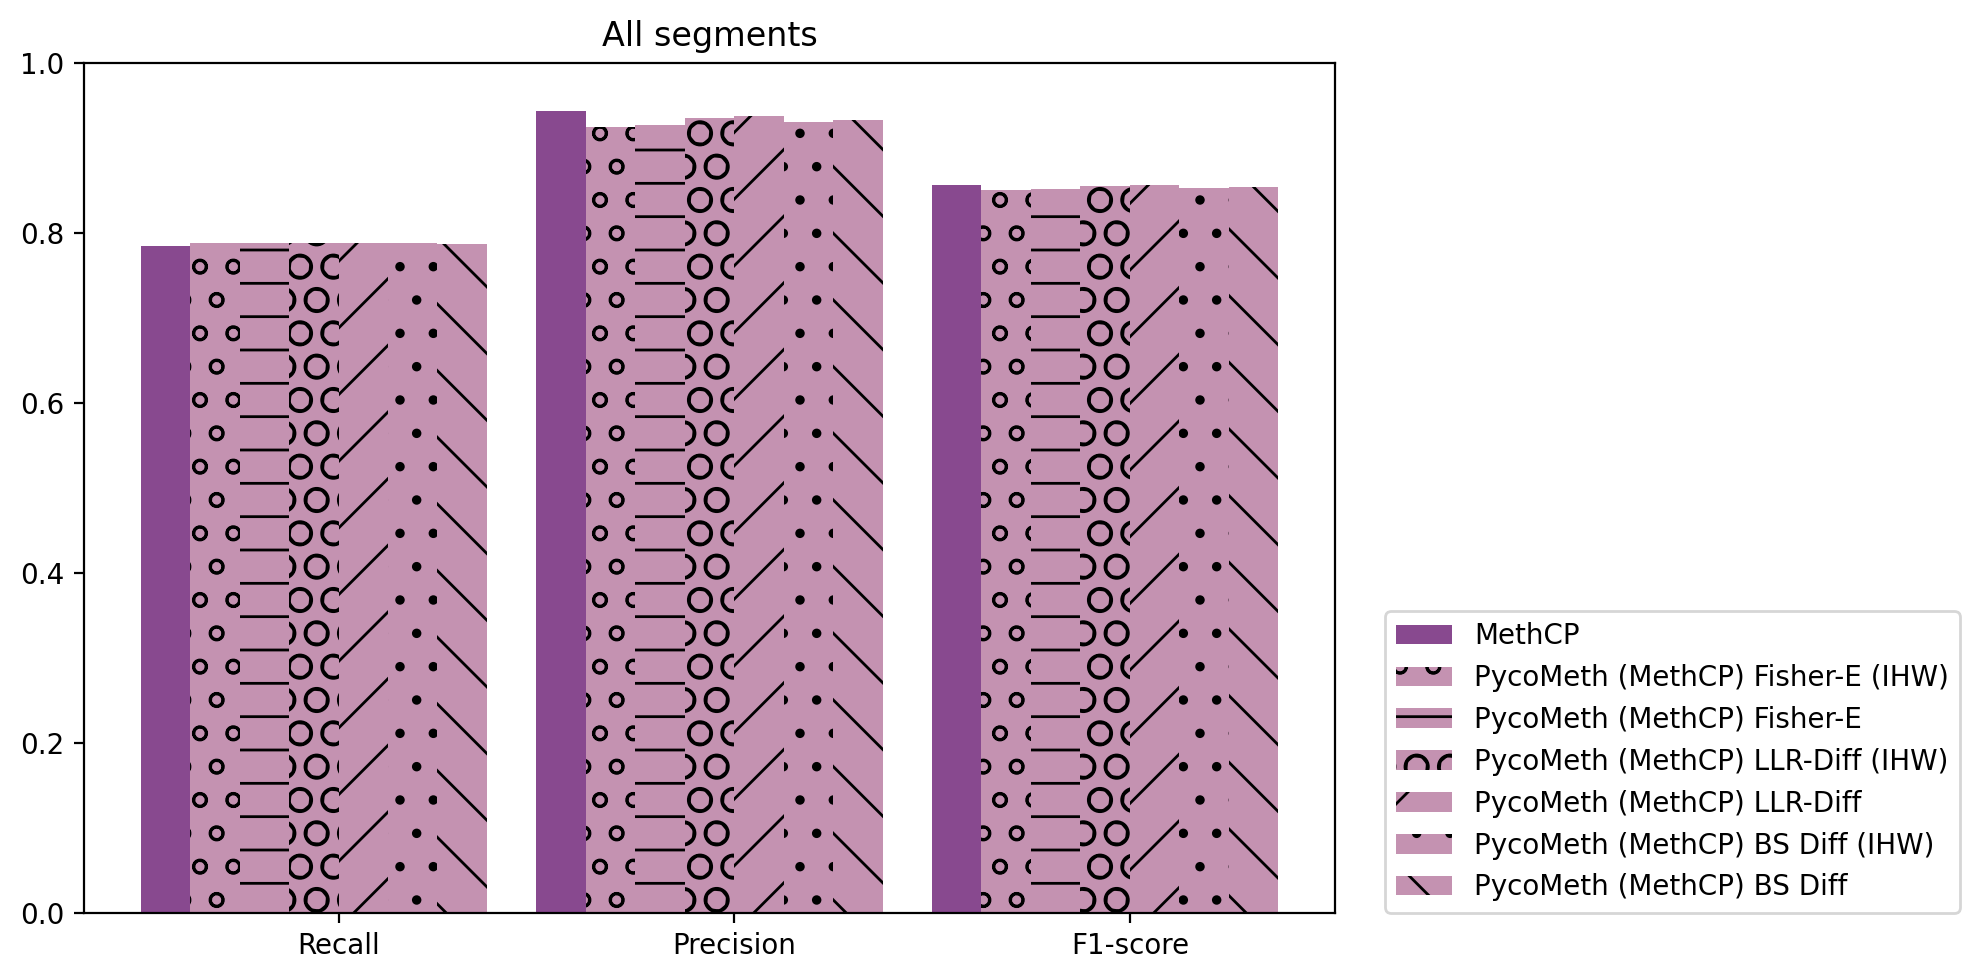

In [131]:
tools_include = ["MethCP", "PycoMeth (MethCP) Fisher-E (IHW)", "PycoMeth (MethCP) Fisher-E", "PycoMeth (MethCP) LLR-Diff (IHW)", "PycoMeth (MethCP) LLR-Diff", "PycoMeth (MethCP) BS Diff (IHW)", "PycoMeth (MethCP) BS Diff"]
tool_colors = {k:results.colors[k] for k in tools_include}
tool_patterns = {k:results.patterns.get(k,"") for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "f1_ihw", tool_colors=tool_colors, tool_patterns=tool_patterns)

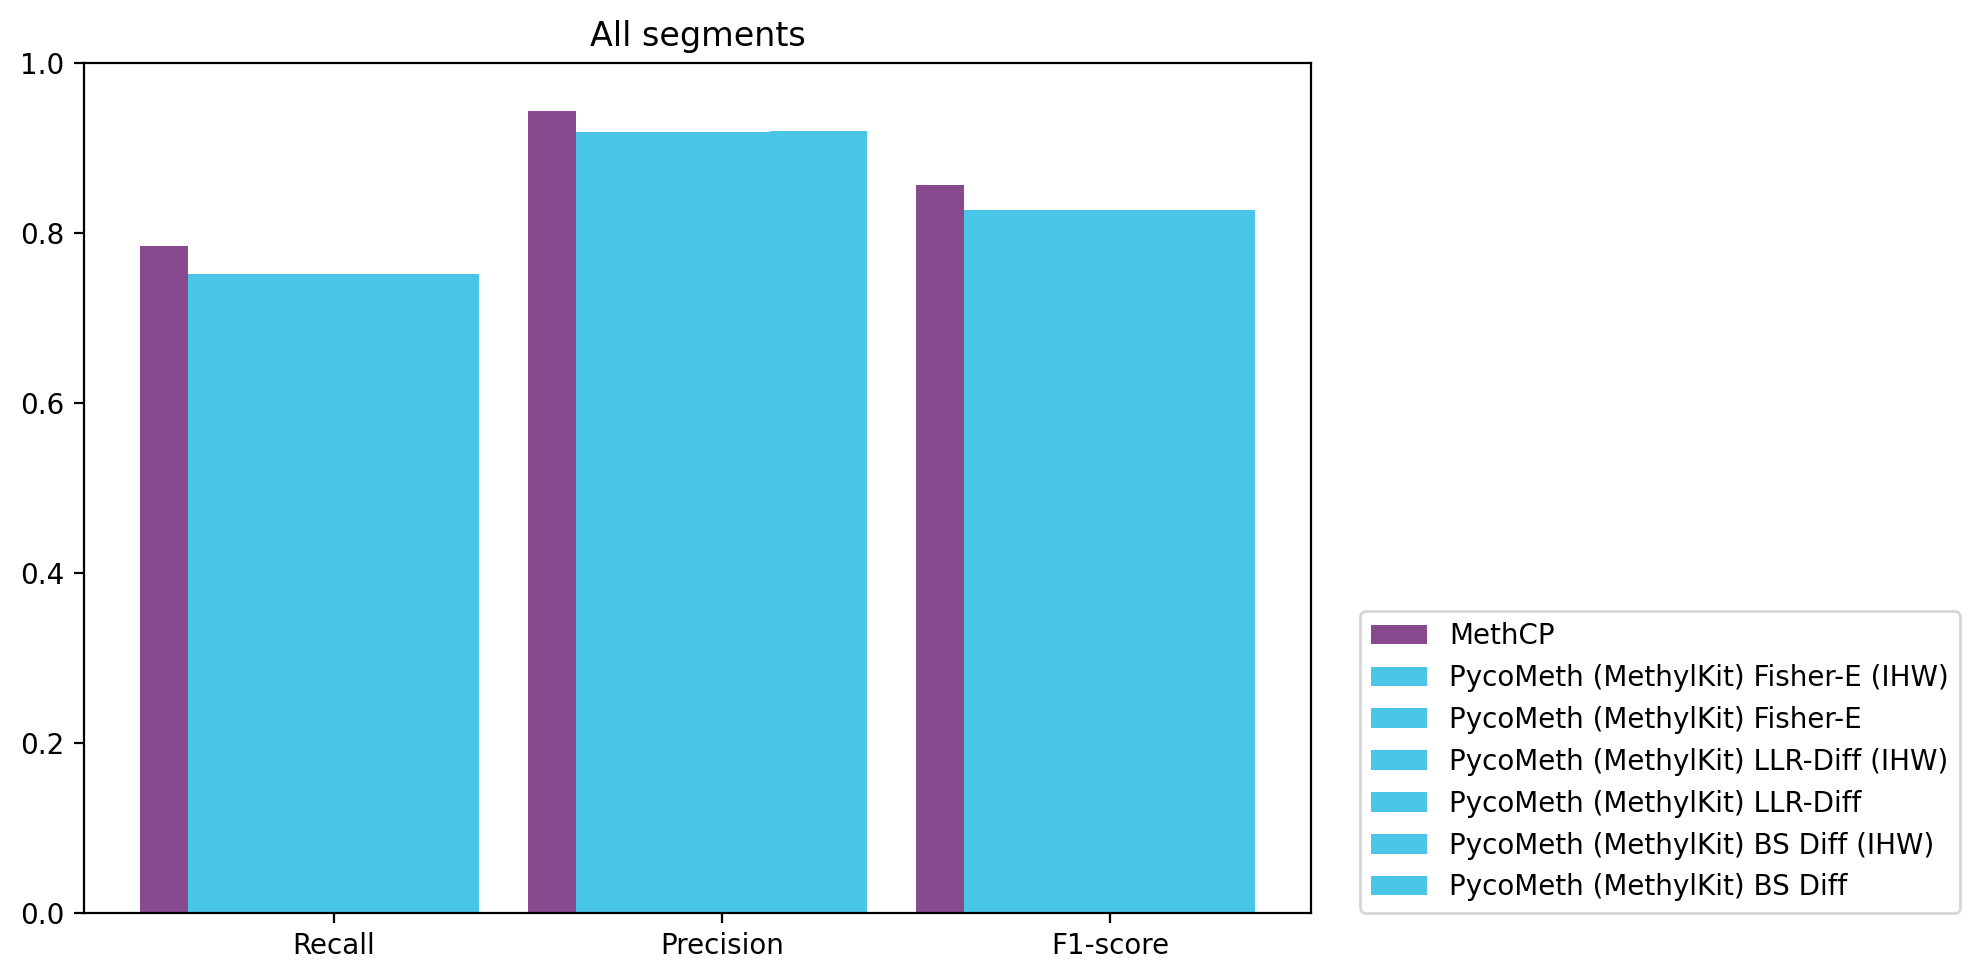

In [132]:
tools_include = ["MethCP", "PycoMeth (MethylKit) Fisher-E (IHW)", "PycoMeth (MethylKit) Fisher-E", "PycoMeth (MethylKit) LLR-Diff (IHW)", "PycoMeth (MethylKit) LLR-Diff", "PycoMeth (MethylKit) BS Diff (IHW)", "PycoMeth (MethylKit) BS Diff"]
tool_colors = {k:results.colors[k] for k in tools_include}
tool_patterns = {k:results.patterns.get(k,"") for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "f1_methylkit", tool_colors=tool_colors)

In [ ]:
plot_measures(gt.loc[gt["segment_type"]==3].copy(), "Fuzzy segments", "roc_fuzzy", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["segment_type"]==2].copy(), "Methylated segments", "roc_methylated", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["segment_type"]==1].copy(), "Unmethylated segments", "roc_unmethylated", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["segment_type"]!=3].copy(), "All but fuzzy segments", "roc_notfuzzy", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["theta"].map(lambda x: abs(x) >= 0.25)].copy(), ">=0.25 change", "roc_effect_size_ge0.25", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["theta"].map(lambda x: abs(x) >= 0.5)].copy(), ">=0.5 change", "roc_effect_size_ge0.5", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["theta"].map(lambda x: abs(x) < 0.25)].copy(), "<0.25 change", "roc_effect_size_lt0.25", tool_colors=tool_colors, tool_patterns=tool_patterns)

In [139]:
results.segments["GT_empirical"] = results.segments["GT"].copy()
results.segments["GT_empirical"]["theta"] = results.segments["GT_empirical"].apply(lambda x: max(abs(x["theta"]), abs(x["diffmet"])) * (-1 if x["theta"] < 0 else 1), axis=1)

In [ ]:
def plot_bar_diffmetcolored(x, key, diffmet_thresholds = [0.2, 0.3, 0.4, 0.6, 0.8, 1.0], cmap="jet"):
    cmap = matplotlib.cm.get_cmap(cmap)
    last_thres = 0.1
    left = 0
    segments = results.segments[key]
    for thres in diffmet_thresholds:
        color = cmap((thres+last_thres)/2)
        idx = segments["diffmet"].map(lambda x: last_thres < abs(x) <= thres)
        n = get_num_dmr_cpgs(key, additional_index=idx)
        plt.barh(x, n, left=left, color=color)
        left += n
        last_thres = thres

In [ ]:
def get_dmrs(key, pval_thres = 0.05, min_diff = 0.1, additional_index=None):
    segments = results.segments[key]
    if additional_index is not None:
        segments = segments.loc[additional_index]
    segments = segments.loc[segments["adj_pvalue"] < pval_thres]
    segments = segments.loc[segments["diffmet"].map(lambda x: abs(x) > min_diff)]
    return segments

def get_num_dmr_cpgs(key, **kwargs):
    dmrs = get_dmrs(key, **kwargs)
    return len(unions(dmrs["CpGs"]))

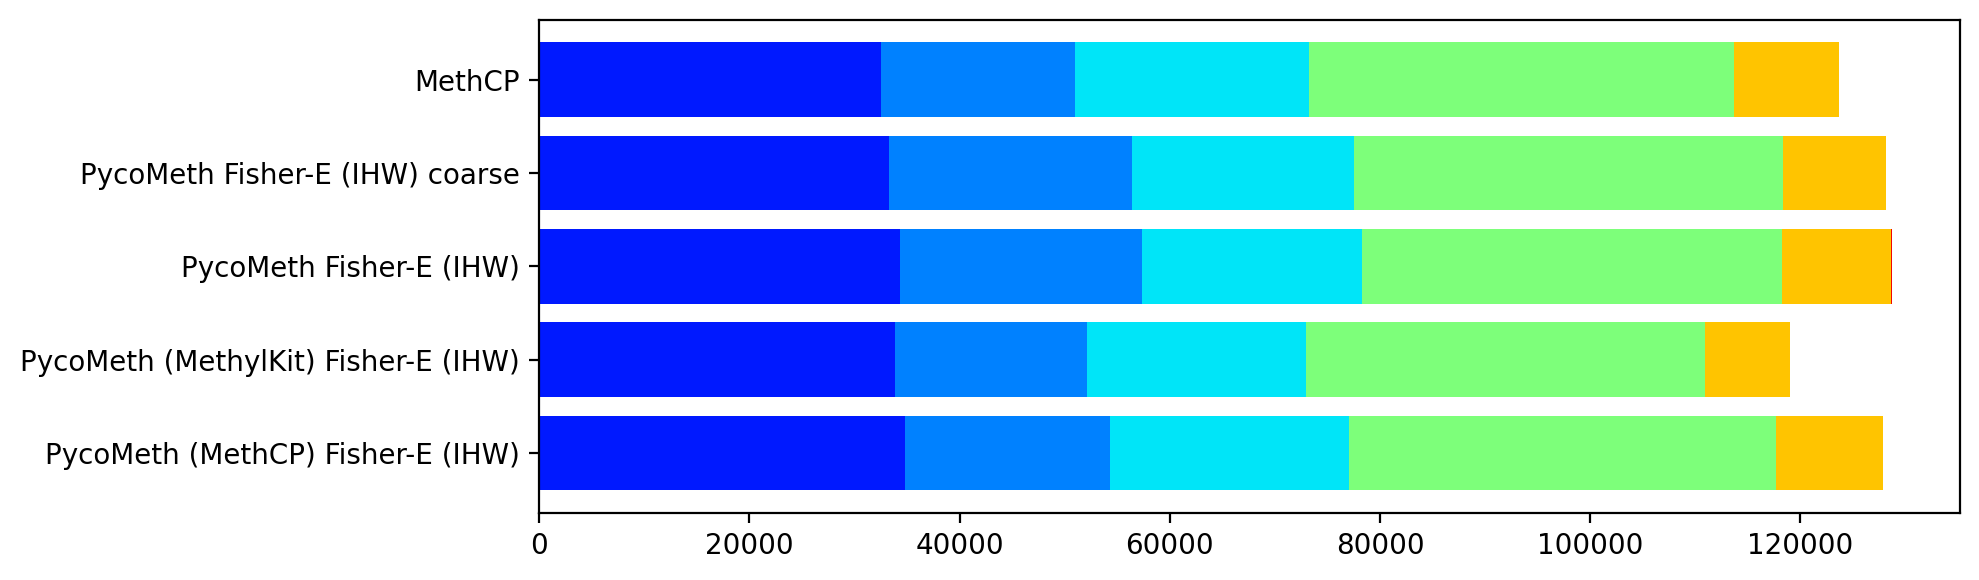

In [134]:
with pa.open_multipage_pdf("simulated_fisher_ihw"):
    tools = ["MethCP", 'PycoMeth Fisher-E (IHW) coarse', 'PycoMeth Fisher-E (IHW)', 'PycoMeth (MethylKit) Fisher-E (IHW)', 'PycoMeth (MethCP) Fisher-E (IHW)'][::-1]
    pa.figure(figsize=(10, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()